# Foreign Exchange Forecasting using LSTMs

In [1]:
import pandas as pd
import numpy as np

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

2023-06-19 21:05:15.480423: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 21:05:15.708314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 21:05:16.695518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

# USD-IDR

## Data Overview
From Google Finance

In [3]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[0]}'
df = pd.read_csv(url)

# Drop unused columns
df = df.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


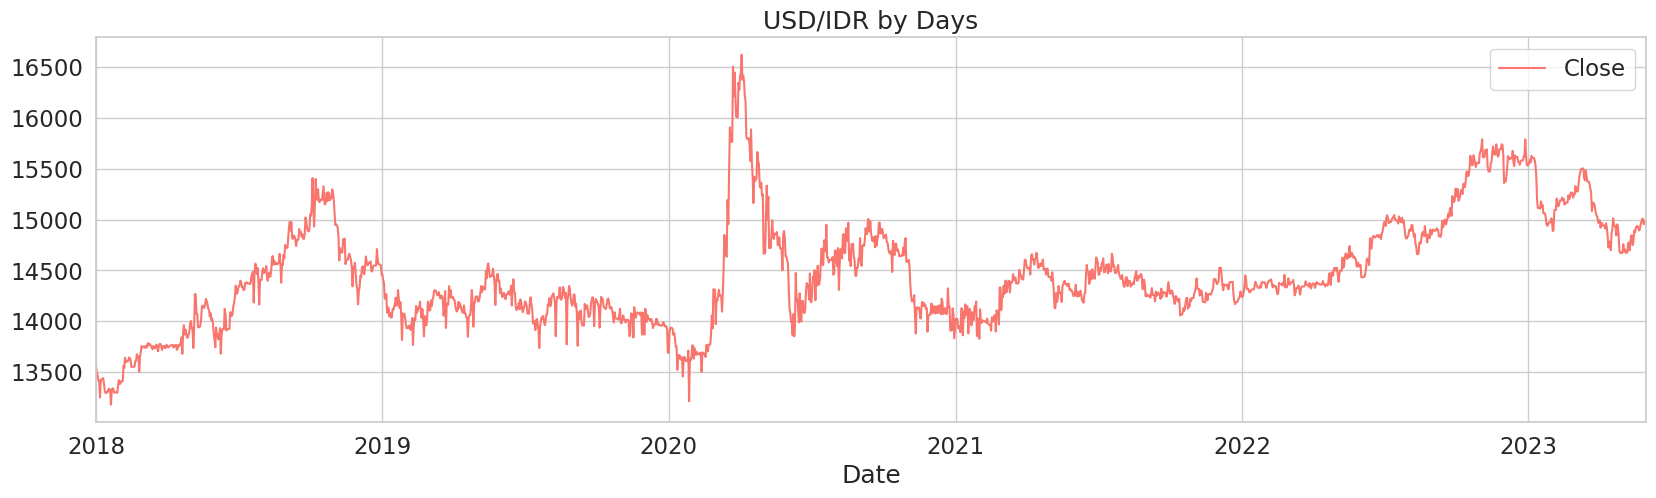

In [4]:
dfplot = df.copy()
dfplot = dfplot.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
dfplot = dfplot.set_index('Date')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dfplot.plot(style='', figsize=(20,5), color=color_pal[0], title='USD/IDR by Days')

## Data preprocessing

### Normalize

In [5]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

### Sliding Window

In [6]:
SEQ_LEN = 6
SPLIT = 0.90

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

## Building LSTM Model with Cross-Validation

In [7]:
FOLD = 5
WINDOW_SIZE = SEQ_LEN - 1
BATCH_SIZE = 32
VAL_SPLIT = 0.1
EPOCH = 50

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

kfold = KFold(n_splits=FOLD, shuffle=True)
tscv = TimeSeriesSplit(n_splits=FOLD)

es = EarlyStopping(monitor='val_loss',
                   patience=5)

In [8]:
fold_no = 1
mae_per_fold = []
loss_per_fold = []
predictions = []

for train, test in kfold.split(inputs, targets):
# for train, test in tscv.split(inputs, targets):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                  metrics=['mae'],
                  optimizer='adam')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(inputs[train],
                        targets[train],
                        epochs=EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_split=VAL_SPLIT)
    
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    prediction = model.predict(inputs[test])
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    mae_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    predictions.append(prediction)

    fold_no += 1

2023-06-19 21:05:28.941607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 21:05:29.080803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 21:05:29.081061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 21:05:29.083687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 21:05:29.083909: I tensorflow/compile

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


2023-06-19 21:05:31.545756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:05:31.547609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:05:31.549083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - ETA: 0s - loss: 0.0625 - mae: 0.2023

2023-06-19 21:05:37.835096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:05:37.836505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:05:37.837448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 7s 78ms/step - loss: 0.0625 - mae: 0.2023 - val_loss: 0.0081 - val_mae: 0.0783
Epoch 2/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0139 - mae: 0.1019 - val_loss: 0.0049 - val_mae: 0.0595
Epoch 3/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0075 - mae: 0.0728 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 4/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0034 - mae: 0.0481 - val_loss: 0.0017 - val_mae: 0.0340
Epoch 5/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0072 - val_mae: 0.0716
Epoch 6/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0027 - val_mae: 0.0425
Epoch 7/50
10/10 [==============================] - 0s 15ms/step - loss: 9.7776e-04 - mae: 0.0238 - val_loss: 0.0023 - val_mae: 0.0400
Epoch 8/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0010 - mae: 0.0

2023-06-19 21:05:45.600859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:05:45.602511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:05:45.603565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50


2023-06-19 21:05:45.858850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:05:45.860455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:05:45.861610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - ETA: 0s - loss: 0.0346 - mae: 0.1483

2023-06-19 21:05:48.769497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:05:48.770814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:05:48.771842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 3s 46ms/step - loss: 0.0346 - mae: 0.1483 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 2/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0059 - mae: 0.0599 - val_loss: 0.0032 - val_mae: 0.0465
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0386 - val_loss: 0.0015 - val_mae: 0.0283
Epoch 4/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0015 - val_mae: 0.0286
Epoch 5/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 6/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0015 - val_mae: 0.0283
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0014 - val_mae: 0.0277
Epoch 8/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0011 - mae: 0.0246 

2023-06-19 21:06:00.304122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:00.305341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:00.306388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50


2023-06-19 21:06:00.757565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:00.758533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:00.760560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/28 [==========================>...] - ETA: 0s - loss: 0.0349 - mae: 0.1410

2023-06-19 21:06:03.734536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:03.736292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:03.737558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 3s 35ms/step - loss: 0.0331 - mae: 0.1357 - val_loss: 0.0072 - val_mae: 0.0738
Epoch 2/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0039 - mae: 0.0445 - val_loss: 0.0019 - val_mae: 0.0361
Epoch 3/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0328 - val_loss: 0.0019 - val_mae: 0.0360
Epoch 4/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0321 - val_loss: 0.0020 - val_mae: 0.0371
Epoch 5/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0339 - val_loss: 0.0021 - val_mae: 0.0370
Epoch 6/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0315 - val_loss: 0.0021 - val_mae: 0.0376
Epoch 7/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0300 - val_loss: 0.0018 - val_mae: 0.0354
Epoch 8/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0303 

2023-06-19 21:06:19.749536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:19.751372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:19.752657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50


2023-06-19 21:06:19.997814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:19.999474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:20.000554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/37 [===========================>..] - ETA: 0s - loss: 0.0296 - mae: 0.1254

2023-06-19 21:06:23.340132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:23.341690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:23.342532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 4s 28ms/step - loss: 0.0283 - mae: 0.1217 - val_loss: 0.0013 - val_mae: 0.0306
Epoch 2/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0033 - mae: 0.0418 - val_loss: 8.0832e-04 - val_mae: 0.0234
Epoch 3/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0314 - val_loss: 8.7329e-04 - val_mae: 0.0215
Epoch 4/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0308 - val_loss: 6.9649e-04 - val_mae: 0.0183
Epoch 5/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0298 - val_loss: 6.7521e-04 - val_mae: 0.0180
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0310 - val_loss: 6.2670e-04 - val_mae: 0.0178
Epoch 7/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0305 - val_loss: 6.1063e-04 - val_mae: 0.0182
Epoch 8/50
37/37 [==============================] - 0s 12ms/step - los

2023-06-19 21:06:44.567662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:44.569358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:44.570420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50


2023-06-19 21:06:44.806886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:44.809114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:44.810662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - ETA: 0s - loss: 0.0234 - mae: 0.1080

2023-06-19 21:06:48.065193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:06:48.066791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:06:48.067710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 4s 24ms/step - loss: 0.0234 - mae: 0.1080 - val_loss: 0.0022 - val_mae: 0.0380
Epoch 2/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0022 - mae: 0.0327 - val_loss: 3.0338e-04 - val_mae: 0.0128
Epoch 3/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0017 - mae: 0.0289 - val_loss: 3.3240e-04 - val_mae: 0.0134
Epoch 4/50
47/47 [==============================] - 0s 11ms/step - loss: 0.0016 - mae: 0.0277 - val_loss: 3.2985e-04 - val_mae: 0.0140
Epoch 5/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0017 - mae: 0.0287 - val_loss: 3.2088e-04 - val_mae: 0.0133
Epoch 6/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - mae: 0.0274 - val_loss: 3.0744e-04 - val_mae: 0.0129
Epoch 7/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0279 - val_loss: 3.1792e-04 - val_mae: 0.0136
Epoch 8/50
47/47 [==============================] - 1s 11ms/step - los

In [9]:
mae_per_fold

[0.026519905775785446,
 0.04091427102684975,
 0.018295947462320328,
 0.01051921583712101,
 0.02421240322291851]

In [10]:
loss_per_fold

[0.0012519452720880508,
 0.003808174515143037,
 0.0006257636705413461,
 0.00020993537327740341,
 0.0008008980075828731]

## Model Evaluation

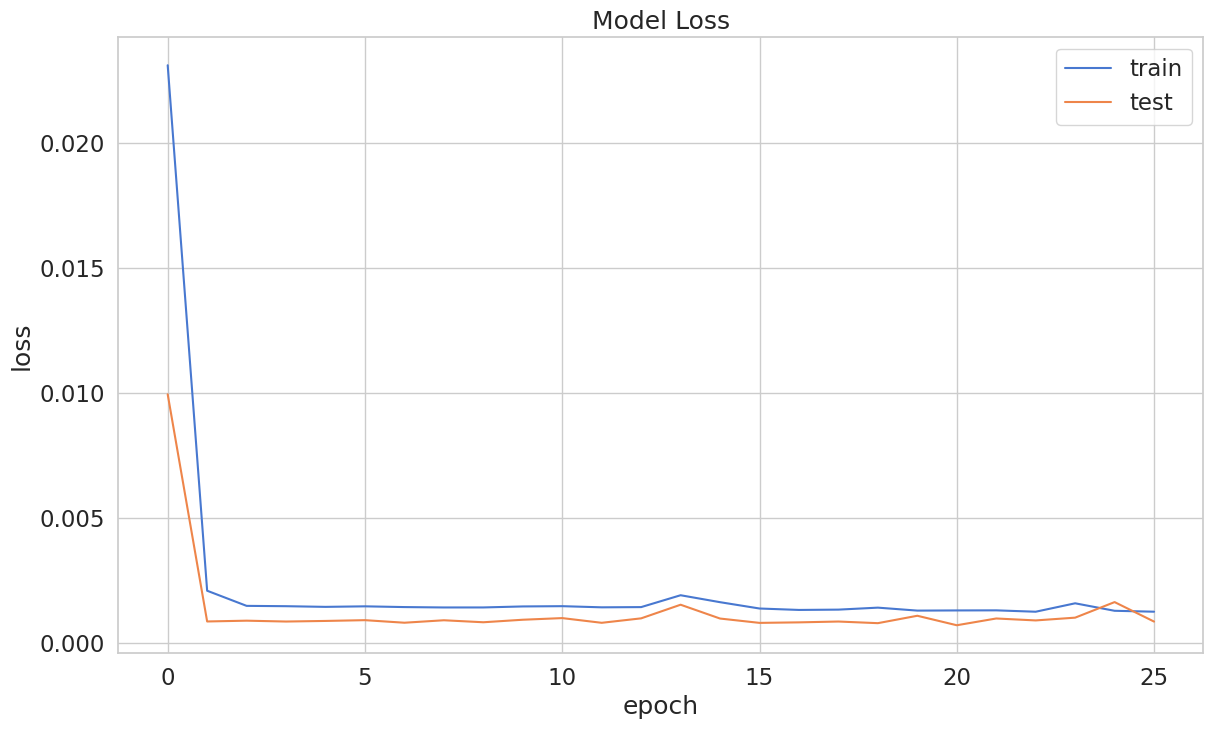

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

In [12]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

2023-06-17 10:48:00.978455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 10:48:00.980386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 10:48:00.981301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 3s

2023-06-17 10:48:01.215950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 10:48:01.217848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 10:48:01.219061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 9ms/step


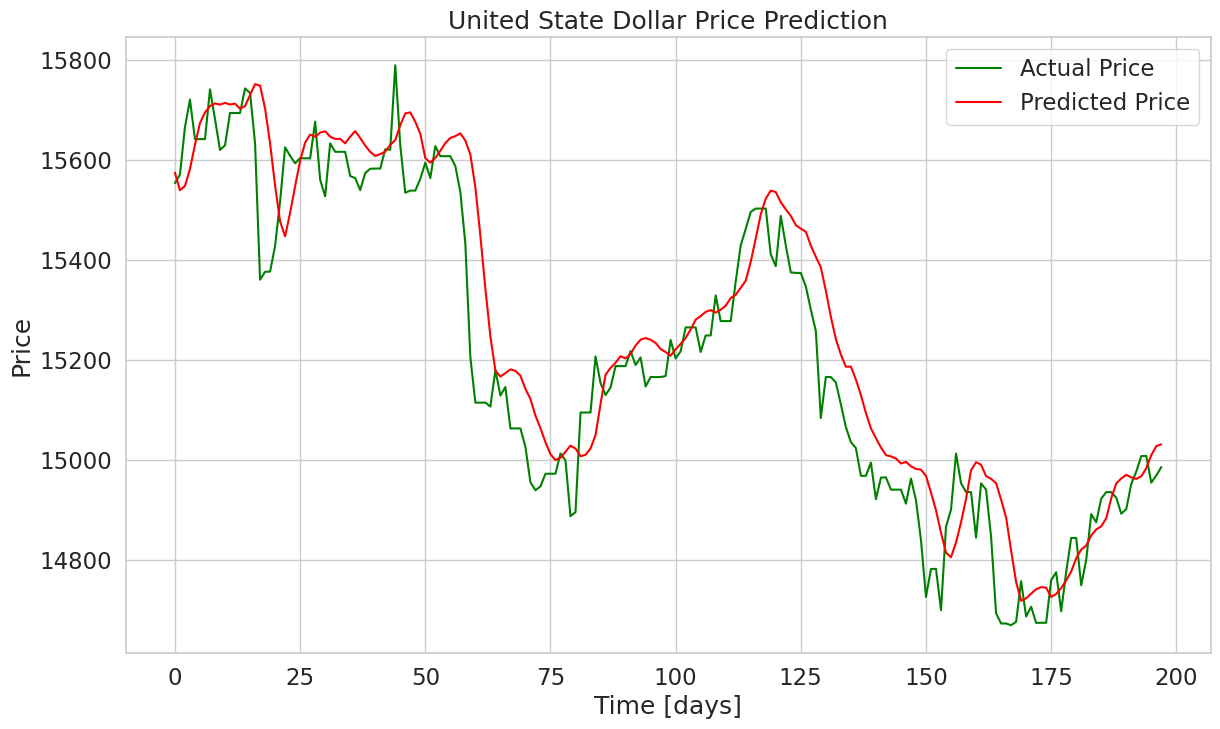

In [13]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('United State Dollar Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [14]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)

matrices(y_test_inverse, y_hat_inverse)

Mean Squared Error for prediction : 12238.271645589508
Mean Absolute Error for prediction : 81.40335582386359
Root Mean Squared Error for prediction : 110.62672211355405
